In [9]:
import numpy as np
import random
import torch
import torch.nn as nn
import gym
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.patches as patches

class Qfunction(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.linear_1 = nn.Linear(state_dim, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, action_dim)
        self.activation = nn.LeakyReLU(0.1)

    def forward(self, states):
        hidden = self.linear_1(states)
        hidden = self.activation(hidden)
        hidden = self.linear_2(hidden)
        hidden = self.activation(hidden)
        actions = self.linear_3(hidden)
        return actions

In [10]:
%matplotlib inline

In [11]:
env = gym.make('LunarLander-v2',continuous = True)

In [12]:
class SDQN:
    def __init__(self, state_dim, action_dim, gamma=0.993, lr=1e-3, batch_size=128, epsilon_decrease=0.01, epsilon_min=0.03):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.q_function = Qfunction(self.state_dim, self.action_dim)
        self.q_function_ = Qfunction(self.state_dim, self.action_dim)
        for target_param in self.q_function_.parameters():
            target_param.data.copy_(target_param.data)
        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = 1
        self.epsilon_decrease = epsilon_decrease
        self.epsilon_min = epsilon_min
        self.memory = []
        self.memory_lim = 150000
        self.optimzaer = torch.optim.Adam(self.q_function.parameters(), lr=lr)

    def get_action(self, state, target= False):
        if(target):
            q_values = self.q_function_(torch.FloatTensor(state))
        else:
            q_values = self.q_function(torch.FloatTensor(state))
        argmax_action = torch.argmax(q_values,dim=-1)
        probs = self.epsilon * np.ones((argmax_action.shape[0],self.action_dim)) / self.action_dim
        probs[np.arange(argmax_action.shape[0]),argmax_action] += 1 - self.epsilon
        action = np.ones(q_values.shape[0], dtype=np.int32)
        for sample in range(q_values.shape[0]):
            action[sample] = np.random.choice(np.arange(self.action_dim), p=probs[sample,:])
        return action
    
    def fit(self, state, action, reward, done, next_state, tau):
        self.memory.append([state, action, reward, int(done), next_state])
        if(len(self.memory)>self.memory_lim):
            self.memory = self.memory[int(self.memory_lim*0.05):]
            self.memory = random.sample(self.memory, int(self.memory_lim*0.9))
            print('clear memory')
        if len(self.memory) > self.batch_size:
            batch = random.sample(self.memory, self.batch_size)
            states, actions, rewards, dones, next_states = map(torch.tensor, list(zip(*batch)))
    
            targets = rewards + self.gamma * (1 - dones) * torch.max(self.q_function_(next_states), dim=1).values
            q_values = self.q_function(states)[torch.arange(self.batch_size), actions]
            
            loss = torch.mean((q_values - targets.detach()) ** 2)
            loss.backward()
            self.optimzaer.step()
            self.optimzaer.zero_grad()
            
            self.soft_update(self.q_function,self.q_function_, tau)
            
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decrease
                
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
%%time
state_dim = env.observation_space.shape[0]
action_dim = 6

episode_n = 1000
t_max = 1000

agent_s = SDQN(state_dim, action_dim,epsilon_decrease=0.03/2000)
action_dict = [[0,0],[1,0],[1,-1],[1,1],[0,1],[0,-1]]

hist_s = []
hist_s_v = []
hist_s_v_disc = []
hist_s_v_ = []
hist_s_v_disc_ = []

for episode in range(episode_n):
    total_reward = 0

    state = env.reset()
    for t in range(t_max):
        action = agent_s.get_action([state])
        next_state, reward, done, _ = env.step(action_dict[action[0]])

        total_reward += reward
        agent_s.fit(state, int(action), reward, done, next_state,tau = 0.005)

        state = next_state

        if done:
            break
    
    hist_s.append(total_reward)
    
    #validate
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], True)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v_.append(total_reward)
        hist_s_v_disc_.append(total_reward_disc)
        
    
    if(episode%10 == 0):
        eps = agent_s.epsilon
        agent_s.epsilon = 0
        total_reward = 0
        total_reward_disc = 0
        rew_mult = 1
        state = env.reset()
        for t in range(t_max):
            action = agent_s.get_action([state], False)
            next_state, reward, done, _ = env.step(action_dict[action[0]])

            total_reward += reward
            
            total_reward_disc += rew_mult*reward
            rew_mult *= agent_s.gamma

            state = next_state

            if done:
                break
        agent_s.epsilon = eps
        
        hist_s_v.append(total_reward)
        hist_s_v_disc.append(total_reward_disc)

    print(f'episode: {episode}, \
rew: {round(np.mean(hist_s[-100:]),2)}, \
v_: {round(np.mean(hist_s_v_[-10:]),2)}, \
v_disc_: {round(np.mean(hist_s_v_disc_[-10:]),2)}, \
v: {round(np.mean(hist_s_v[-10:]),2)}, \
v_disc: {round(np.mean(hist_s_v_disc[-10:]),2)}, \
epsilon: {round(agent_s.epsilon,2)}, \
mem: {len(agent_s.memory)}')

episode: 0, rew: -60.9, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 1, mem: 93
episode: 1, rew: -69.36, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 1.0, mem: 202
episode: 2, rew: -66.69, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 1.0, mem: 332
episode: 3, rew: -171.25, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 1.0, mem: 417
episode: 4, rew: -207.36, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 0.99, mem: 524
episode: 5, rew: -247.46, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 0.99, mem: 641
episode: 6, rew: -225.97, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 0.99, mem: 733
episode: 7, rew: -217.93, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 0.99, mem: 860
episode: 8, rew: -247.0, v_: -403.06, v_disc_: -302.74, v: -569.74, v_disc: -395.38, epsilon: 0.99, mem: 955
episode: 9, rew: -261.

episode: 74, rew: -311.91, v_: -577.53, v_disc_: -345.97, v: -426.05, v_disc: -301.08, epsilon: 0.85, mem: 9948
episode: 75, rew: -308.89, v_: -577.53, v_disc_: -345.97, v: -426.05, v_disc: -301.08, epsilon: 0.85, mem: 10040
episode: 76, rew: -311.29, v_: -577.53, v_disc_: -345.97, v: -426.05, v_disc: -301.08, epsilon: 0.85, mem: 10183
episode: 77, rew: -309.81, v_: -577.53, v_disc_: -345.97, v: -426.05, v_disc: -301.08, epsilon: 0.85, mem: 10285
episode: 78, rew: -308.75, v_: -577.53, v_disc_: -345.97, v: -426.05, v_disc: -301.08, epsilon: 0.85, mem: 10411
episode: 79, rew: -306.35, v_: -577.53, v_disc_: -345.97, v: -426.05, v_disc: -301.08, epsilon: 0.84, mem: 10595
episode: 80, rew: -309.22, v_: -554.1, v_disc_: -330.59, v: -403.7, v_disc: -286.39, epsilon: 0.84, mem: 10741
episode: 81, rew: -309.16, v_: -554.1, v_disc_: -330.59, v: -403.7, v_disc: -286.39, epsilon: 0.84, mem: 10811
episode: 82, rew: -310.16, v_: -554.1, v_disc_: -330.59, v: -403.7, v_disc: -286.39, epsilon: 0.84, m

episode: 147, rew: -291.41, v_: -358.74, v_disc_: -219.98, v: -327.2, v_disc: -232.48, epsilon: 0.74, mem: 17738
episode: 148, rew: -288.96, v_: -358.74, v_disc_: -219.98, v: -327.2, v_disc: -232.48, epsilon: 0.73, mem: 17915
episode: 149, rew: -287.67, v_: -358.74, v_disc_: -219.98, v: -327.2, v_disc: -232.48, epsilon: 0.73, mem: 18044
episode: 150, rew: -286.47, v_: -284.34, v_disc_: -184.67, v: -324.9, v_disc: -230.4, epsilon: 0.73, mem: 18188
episode: 151, rew: -281.26, v_: -284.34, v_disc_: -184.67, v: -324.9, v_disc: -230.4, epsilon: 0.73, mem: 18287
episode: 152, rew: -280.16, v_: -284.34, v_disc_: -184.67, v: -324.9, v_disc: -230.4, epsilon: 0.73, mem: 18357
episode: 153, rew: -279.35, v_: -284.34, v_disc_: -184.67, v: -324.9, v_disc: -230.4, epsilon: 0.72, mem: 18501
episode: 154, rew: -276.63, v_: -284.34, v_disc_: -184.67, v: -324.9, v_disc: -230.4, epsilon: 0.72, mem: 18593
episode: 155, rew: -274.29, v_: -284.34, v_disc_: -184.67, v: -324.9, v_disc: -230.4, epsilon: 0.72, 

episode: 220, rew: -191.68, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.27, mem: 48937
episode: 221, rew: -194.25, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.27, mem: 49111
episode: 222, rew: -193.05, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.25, mem: 50111
episode: 223, rew: -190.72, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.24, mem: 51111
episode: 224, rew: -189.43, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.22, mem: 52111
episode: 225, rew: -185.57, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.21, mem: 53111
episode: 226, rew: -185.08, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.19, mem: 54111
episode: 227, rew: -183.89, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.19, mem: 54321
episode: 228, rew: -180.84, v_: -131.09, v_disc_: -44.46, v: -182.87, v_disc: -60.74, epsilon: 0.17, mem

episode: 294, rew: -92.46, v_: -74.86, v_disc_: 1.94, v: -213.37, v_disc: -61.1, epsilon: 0.03, mem: 113728
episode: 295, rew: -94.27, v_: -74.86, v_disc_: 1.94, v: -213.37, v_disc: -61.1, epsilon: 0.03, mem: 114728
episode: 296, rew: -95.21, v_: -74.86, v_disc_: 1.94, v: -213.37, v_disc: -61.1, epsilon: 0.03, mem: 115728
episode: 297, rew: -94.89, v_: -74.86, v_disc_: 1.94, v: -213.37, v_disc: -61.1, epsilon: 0.03, mem: 116728
episode: 298, rew: -96.92, v_: -74.86, v_disc_: 1.94, v: -213.37, v_disc: -61.1, epsilon: 0.03, mem: 117051
episode: 299, rew: -99.28, v_: -74.86, v_disc_: 1.94, v: -213.37, v_disc: -61.1, epsilon: 0.03, mem: 117184
episode: 300, rew: -97.17, v_: -96.33, v_disc_: -12.68, v: -231.33, v_disc: -74.92, epsilon: 0.03, mem: 117890
episode: 301, rew: -94.7, v_: -96.33, v_disc_: -12.68, v: -231.33, v_disc: -74.92, epsilon: 0.03, mem: 118477
episode: 302, rew: -94.72, v_: -96.33, v_disc_: -12.68, v: -231.33, v_disc: -74.92, epsilon: 0.03, mem: 119477
episode: 303, rew: -

episode: 369, rew: -77.67, v_: -35.75, v_disc_: -5.27, v: -81.48, v_disc: -68.62, epsilon: 0.03, mem: 139974
episode: 370, rew: -76.87, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 140974
episode: 371, rew: -76.79, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 141974
episode: 372, rew: -76.4, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 142974
episode: 373, rew: -77.11, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 143974
episode: 374, rew: -77.99, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 144974
episode: 375, rew: -76.84, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 145876
episode: 376, rew: -77.77, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 146876
episode: 377, rew: -78.68, v_: -37.17, v_disc_: -4.67, v: -56.96, v_disc: -57.62, epsilon: 0.03, mem: 147876
episode: 378, rew: -

episode: 445, rew: 20.67, v_: 50.27, v_disc_: 27.41, v: 38.73, v_disc: -0.98, epsilon: 0.03, mem: 141918
episode: 446, rew: 23.67, v_: 50.27, v_disc_: 27.41, v: 38.73, v_disc: -0.98, epsilon: 0.03, mem: 142383
episode: 447, rew: 32.53, v_: 50.27, v_disc_: 27.41, v: 38.73, v_disc: -0.98, epsilon: 0.03, mem: 142815
episode: 448, rew: 32.98, v_: 50.27, v_disc_: 27.41, v: 38.73, v_disc: -0.98, epsilon: 0.03, mem: 143330
episode: 449, rew: 30.48, v_: 50.27, v_disc_: 27.41, v: 38.73, v_disc: -0.98, epsilon: 0.03, mem: 144330
episode: 450, rew: 32.99, v_: 74.26, v_disc_: 36.75, v: 15.84, v_disc: 11.13, epsilon: 0.03, mem: 144661
episode: 451, rew: 31.71, v_: 74.26, v_disc_: 36.75, v: 15.84, v_disc: 11.13, epsilon: 0.03, mem: 145661
episode: 452, rew: 36.24, v_: 74.26, v_disc_: 36.75, v: 15.84, v_disc: 11.13, epsilon: 0.03, mem: 146167
episode: 453, rew: 37.13, v_: 74.26, v_disc_: 36.75, v: 15.84, v_disc: 11.13, epsilon: 0.03, mem: 146945
episode: 454, rew: 42.16, v_: 74.26, v_disc_: 36.75, v:

episode: 522, rew: 179.22, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 143866
episode: 523, rew: 178.7, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 144459
episode: 524, rew: 176.02, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 144603
episode: 525, rew: 176.5, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 144824
episode: 526, rew: 173.69, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 144944
episode: 527, rew: 174.1, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 145197
episode: 528, rew: 174.74, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 145478
episode: 529, rew: 174.61, v_: 141.41, v_disc_: 50.96, v: 103.98, v_disc: 49.3, epsilon: 0.03, mem: 145839
episode: 530, rew: 171.66, v_: 139.14, v_disc_: 49.48, v: 103.54, v_disc: 50.97, epsilon: 0.03, mem: 145975
episode: 531, rew: 171.19, v_: 139.14, 

episode: 599, rew: 200.09, v_: 201.73, v_disc_: 70.74, v: 179.23, v_disc: 62.65, epsilon: 0.03, mem: 146560
episode: 600, rew: 200.23, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 146819
episode: 601, rew: 201.25, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 147330
episode: 602, rew: 201.23, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 147638
episode: 603, rew: 204.12, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 147971
episode: 604, rew: 204.29, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 148271
episode: 605, rew: 204.54, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 148597
episode: 606, rew: 207.36, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 149098
episode: 607, rew: 207.47, v_: 231.61, v_disc_: 81.23, v: 148.38, v_disc: 59.9, epsilon: 0.03, mem: 149852
clear memory
episode: 608, rew: 210.

episode: 675, rew: 234.23, v_: 227.88, v_disc_: 72.15, v: 186.77, v_disc: 63.2, epsilon: 0.03, mem: 147382
episode: 676, rew: 236.0, v_: 227.88, v_disc_: 72.15, v: 186.77, v_disc: 63.2, epsilon: 0.03, mem: 147635
episode: 677, rew: 236.2, v_: 227.88, v_disc_: 72.15, v: 186.77, v_disc: 63.2, epsilon: 0.03, mem: 148087
episode: 678, rew: 236.37, v_: 227.88, v_disc_: 72.15, v: 186.77, v_disc: 63.2, epsilon: 0.03, mem: 148908
episode: 679, rew: 236.46, v_: 227.88, v_disc_: 72.15, v: 186.77, v_disc: 63.2, epsilon: 0.03, mem: 149196
clear memory
episode: 680, rew: 235.74, v_: 231.13, v_disc_: 74.02, v: 34.94, v_disc: 44.16, epsilon: 0.03, mem: 135195
episode: 681, rew: 235.7, v_: 231.13, v_disc_: 74.02, v: 34.94, v_disc: 44.16, epsilon: 0.03, mem: 135419
episode: 682, rew: 235.21, v_: 231.13, v_disc_: 74.02, v: 34.94, v_disc: 44.16, epsilon: 0.03, mem: 135783
episode: 683, rew: 235.66, v_: 231.13, v_disc_: 74.02, v: 34.94, v_disc: 44.16, epsilon: 0.03, mem: 136180
episode: 684, rew: 235.0, v

episode: 752, rew: 182.01, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 149619
episode: 753, rew: 181.7, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 149812
clear memory
episode: 754, rew: 181.39, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 135379
episode: 755, rew: 182.81, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 135858
episode: 756, rew: 180.04, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 136070
episode: 757, rew: 180.17, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 136583
episode: 758, rew: 176.3, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 137583
episode: 759, rew: 179.22, v_: 148.44, v_disc_: 33.36, v: -60.26, v_disc: 24.35, epsilon: 0.03, mem: 137904
episode: 760, rew: 178.79, v_: 149.64, v_disc_: 35.26, v: -47.82, v_disc: 29.26, epsilon: 0.03, mem: 138254
episode: 761, rew

episode: 829, rew: 146.46, v_: 145.5, v_disc_: 50.09, v: 4.66, v_disc: 19.09, epsilon: 0.03, mem: 138557
episode: 830, rew: 146.23, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 138970
episode: 831, rew: 146.49, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 139422
episode: 832, rew: 146.13, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 139949
episode: 833, rew: 146.33, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 140273
episode: 834, rew: 146.41, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 140487
episode: 835, rew: 146.93, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 140764
episode: 836, rew: 147.21, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 141034
episode: 837, rew: 147.0, v_: 120.13, v_disc_: 38.39, v: -13.54, v_disc: 14.35, epsilon: 0.03, mem: 141262
episode: 838, rew: 147.12, v_: 1

episode: 906, rew: 212.71, v_: 216.81, v_disc_: 77.23, v: 139.36, v_disc: 34.71, epsilon: 0.03, mem: 149399
episode: 907, rew: 212.4, v_: 216.81, v_disc_: 77.23, v: 139.36, v_disc: 34.71, epsilon: 0.03, mem: 149680
episode: 908, rew: 216.4, v_: 216.81, v_disc_: 77.23, v: 139.36, v_disc: 34.71, epsilon: 0.03, mem: 149893
clear memory
episode: 909, rew: 219.34, v_: 216.81, v_disc_: 77.23, v: 139.36, v_disc: 34.71, epsilon: 0.03, mem: 135196
episode: 910, rew: 210.92, v_: 220.66, v_disc_: 77.8, v: 167.94, v_disc: 45.32, epsilon: 0.03, mem: 135382
episode: 911, rew: 214.33, v_: 220.66, v_disc_: 77.8, v: 167.94, v_disc: 45.32, epsilon: 0.03, mem: 135629
episode: 912, rew: 214.55, v_: 220.66, v_disc_: 77.8, v: 167.94, v_disc: 45.32, epsilon: 0.03, mem: 135928
episode: 913, rew: 219.81, v_: 220.66, v_disc_: 77.8, v: 167.94, v_disc: 45.32, epsilon: 0.03, mem: 136196
episode: 914, rew: 221.04, v_: 220.66, v_disc_: 77.8, v: 167.94, v_disc: 45.32, epsilon: 0.03, mem: 136543
episode: 915, rew: 222

episode: 983, rew: -48.09, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 143478
episode: 984, rew: -56.51, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 143614
episode: 985, rew: -70.9, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 143962
episode: 986, rew: -86.55, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 144409
episode: 987, rew: -89.32, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 145409
episode: 988, rew: -99.92, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 145793
episode: 989, rew: -108.23, v_: -87.99, v_disc_: -40.9, v: -111.4, v_disc: -52.07, epsilon: 0.03, mem: 146196
episode: 990, rew: -120.07, v_: -158.91, v_disc_: -55.25, v: -179.7, v_disc: -65.17, epsilon: 0.03, mem: 147189
episode: 991, rew: -124.3, v_: -158.91, v_disc_: -55.25, v: -179.7, v_disc: -65.17, epsilon: 0.03, mem: 148189
episode: 992, 

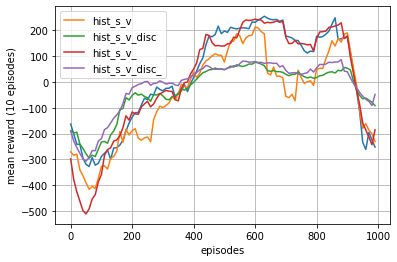

In [14]:
plt.grid(True)
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s[::10],np.ones(10)/10,mode='same'))
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v,np.ones(10)/10,mode='same'),label='hist_s_v')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc,np.ones(10)/10,mode='same'),label='hist_s_v_disc')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_,np.ones(10)/10,mode='same'),label='hist_s_v_')
plt.plot([i for i in range(0,len(hist_s[::10])*10,10)],np.convolve(hist_s_v_disc_,np.ones(10)/10,mode='same'),label='hist_s_v_disc_')
plt.xlabel('episodes')
plt.ylabel('mean reward (10 episodes)')
plt.legend()

In [15]:
hist = np.array([[i for i in range(len(hist_s))],hist_s]).T

In [16]:
np.savetxt('st1.txt',hist)